In [1]:
### from mnist import MNIST
import random

import scipy
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift, estimate_bandwidth

import pandas as pd

from scipy import stats
from scipy.stats import beta
from math import sin
from random import randint

import matplotlib.pyplot as plt
import itertools as it

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
init_notebook_mode(connected=True)

import collections
from IPython.display import clear_output

def recursively_default_dict():
        return collections.defaultdict(recursively_default_dict)

from matplotlib.collections import BrokenBarHCollection
import re

from random import shuffle

from random import sample

import Ideogram_tools
import Modules_tools

## Population assignment priors

In the jupyter notebook **Digits** we borrowed some code to read the MNIST digits data set into python. The MNIST data contains 60,000 labelled matrices of hand-written digits. Each matrix consists in 28 by 28 pixels.

- for more information viste the [MNIST website](http://yann.lecun.com/exdb/mnist/)

We then explored estimating the density of positive pixel values for a single digit. We found that kernel density estimation (KDE) provided a satisfactory description of the density of positive pixels in a single image.

The MNIST data is traditionally used to test and develop pattern recognition algrithms (refer to the website for references). We explored the use of the digit densities estimated to discriminate digits, with poor results. We used PCA, and better results could probably be obtained. In this notebook we will make a different use of this data.

We are interested in the description provided by KDE of a 2D pattern. This is because the description provided by KDE is not a representation, but a working description. Through the KDE tool we obtain a transformation of points in space that is informative of the density of the digit we trained on. 


We are going to use the KDE transformation extracted from a single image to establish priors for the local population assignment of simulated haplotypes.

This execise has absolutely no population genetics justification whatsoever. It is an example of what could be done simulation-wise if real priors were provided.

### Simulating haplotypes.

We will begin by establishing our populations as allele frequence vectors. The process is extensively covered in noteboooks **1** of the [Genetic Data Analysis repository](https://github.com/SantosJGND/Genetic-data-analysis). Notebooks **10** and **11** of the same repository explores the uses of this protcol for the simulation of genomic differentiation and individual admixture.

In [2]:
# Simulate frequency vectors. 
# We must first define the number of populations, the length of the haplotypes desired, and their respective population sizes
L= 150

import itertools as it
n= 500

# Vary a (beta distribution parameter).
a_range= np.linspace(1,2,15)
a_set= [i for i in a_range for _ in range(n)]

# vary b.
b_range= np.linspace(0.1,.4,15)
b_set= [i for i in b_range for _ in range(n)]

## length of haplotypes to extract.
L_set= [L] * n * 15


background_1= np.array([a_set,b_set,L_set]).T

vector_lib= []
for k in range(background_1.shape[0]):
    
    probs= beta.rvs(background_1[k,0], background_1[k,1], size=int(background_1[k,2]))
    probs[(probs > 1)]= 1
    
    
    vector_lib.append(probs)

vector_lib= np.array(vector_lib)

In [3]:
n_comp = 100

pca = PCA(n_components=n_comp, whiten=False,svd_solver='randomized')
features = pca.fit_transform(vector_lib)

print("; ".join(['PC{0}: {1}'.format(x+1,round(pca.explained_variance_ratio_[x],3)) for x in range(n_comp)]))
print('features shape: {}'.format(features.shape))

PC1: 0.019; PC2: 0.008; PC3: 0.008; PC4: 0.008; PC5: 0.008; PC6: 0.008; PC7: 0.008; PC8: 0.008; PC9: 0.008; PC10: 0.008; PC11: 0.008; PC12: 0.008; PC13: 0.008; PC14: 0.008; PC15: 0.008; PC16: 0.008; PC17: 0.008; PC18: 0.008; PC19: 0.008; PC20: 0.008; PC21: 0.008; PC22: 0.008; PC23: 0.008; PC24: 0.008; PC25: 0.008; PC26: 0.008; PC27: 0.008; PC28: 0.008; PC29: 0.007; PC30: 0.007; PC31: 0.007; PC32: 0.007; PC33: 0.007; PC34: 0.007; PC35: 0.007; PC36: 0.007; PC37: 0.007; PC38: 0.007; PC39: 0.007; PC40: 0.007; PC41: 0.007; PC42: 0.007; PC43: 0.007; PC44: 0.007; PC45: 0.007; PC46: 0.007; PC47: 0.007; PC48: 0.007; PC49: 0.007; PC50: 0.007; PC51: 0.007; PC52: 0.007; PC53: 0.007; PC54: 0.007; PC55: 0.007; PC56: 0.007; PC57: 0.007; PC58: 0.007; PC59: 0.007; PC60: 0.007; PC61: 0.007; PC62: 0.007; PC63: 0.007; PC64: 0.007; PC65: 0.007; PC66: 0.007; PC67: 0.007; PC68: 0.007; PC69: 0.007; PC70: 0.006; PC71: 0.006; PC72: 0.006; PC73: 0.006; PC74: 0.006; PC75: 0.006; PC76: 0.006; PC77: 0.006; PC78: 0.

In [4]:
#### Let's plot the first 3 coordinates nonetheless.
####
fig_data= [go.Scatter3d(
        x = features[:,0],
        y = features[:,1],
        z = features[:,2],
        mode= "markers",
        text= ['a: {}; b: {}, L: {}; index = {}'.format(background_1[k,0],background_1[k,1],background_1[k,2], k) for k in range(background_1.shape[0])],
        marker= {
        'line': {'width': 0},
        'size': 4,
        'symbol': 'circle',
      "opacity": .8
      }
    )]


layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=fig_data, layout=layout)
iplot(fig)


**Fig. 1** PCA of frequency vectors generated. All frequency vectors were generated  by random sampling from a beta distribution with specific a and b shape parameters. Hover over the points to observe those values. This information can be used to select the populations chosen in the next block.

In [5]:
#### We'll have to first change our fst function.
def return_fsts(vector_lib,pops):
    
    H= {pop: [1-(vector_lib[pop,x]**2 + (1 - vector_lib[pop,x])**2) for x in range(vector_lib.shape[1])] for pop in pops}
    Store= []
    for comb in it.combinations(pops,2):
        P= [sum([vector_lib[x,i] for x in comb]) / len(comb) for i in range(vector_lib.shape[1])]
        HT= [2 * P[x] * (1 - P[x]) for x in range(len(P))]
        Fst= np.mean([(HT[x] - np.mean([H[p][x] for p in comb])) / HT[x] for x in range(len(P))])
        
        Store.append([comb,Fst])
    
    ### total fst:
    P= [sum([vector_lib[x,i] for x in pops]) / len(pops) for i in range(vector_lib.shape[1])]
    HT= [2 * P[x] * (1 - P[x]) for x in range(len(P))]
    FST= np.mean([(HT[x] - np.mean([H[p][x] for p in pops])) / HT[x] for x in range(len(P))])
    
    return pd.DataFrame(Store,columns= ['pops','fst']),FST



def return_fsts2(freq_array):
    pops= range(freq_array.shape[0])
    H= {pop: [1-(freq_array[pop,x]**2 + (1 - freq_array[pop,x])**2) for x in range(freq_array.shape[1])] for pop in range(freq_array.shape[0])}
    Store= []

    for comb in it.combinations(H.keys(),2):
        P= [sum([freq_array[x,i] for x in comb]) / len(comb) for i in range(freq_array.shape[1])]
        HT= [2 * P[x] * (1 - P[x]) for x in range(len(P))]
        per_locus_fst= [[(HT[x] - np.mean([H[p][x] for p in comb])) / HT[x],0][int(HT[x] == 0)] for x in range(len(P))]
        per_locus_fst= np.nan_to_num(per_locus_fst)
        Fst= np.mean(per_locus_fst)

        Store.append([comb,Fst])
    
    
    ### total fst:
    P= [sum([freq_array[x,i] for x in pops]) / len(pops) for i in range(freq_array.shape[1])]
    HT= [2 * P[x] * (1 - P[x]) for x in range(len(P))]
    FST= np.mean([(HT[x] - np.mean([H[p][x] for p in pops])) / HT[x] for x in range(len(P))])
    
    return pd.DataFrame(Store,columns= ['pops','fst'])


## MNIST data

We begin by importing the MNIST data, choosing one random image and estimating the density of the digit within, as we did in the **Digits** notebook.

In [6]:
######## 

In [54]:
from mnist import MNIST
import random

mndata = MNIST('MNIST_data')

images, labels = mndata.load_training()
# or
images, labels = mndata.load_testing()


In [62]:
def get_numbers(N,images,labels):
    numbers= {}
    
    number_keys= np.random.choice(list(range(0, len(images))),N,replace= False)
    
    
    for n in range(N):
        clear_output()

        index = random.randrange(0, len(images))  # choose an index ;-)

        print(mndata.display(images[index]))

        print('selected digit: {}'.format(labels[index]))

        Bit_image= images[index]
        
        numbers[n]= {
            'image': Bit_image,
            'label': labels[index],
            'index':index
        }
    
    return numbers

n_images= 2
Numbers= get_numbers(n_images,images,labels)
## setting up our map.
Nrow= 28
Ncol= 28


............................
............................
............................
............................
............................
...............@@@@@........
...........@@@@@@@@@@@......
..........@@@@@@@@@@@@@.....
..........@@@@@@@..@@@@.....
.........@@@@@@@....@@@.....
........@@@@@@@@.....@@@....
.......@@@@@.@@@.....@@@....
......@@@@@..@@@.....@@@....
......@@@@@..@@@.....@@@....
......@@@@...........@@@....
.....@@@@............@@@....
.....@@@@...........@@@.....
.....@@@@..........@@@@.....
.....@@@@.........@@@@@.....
......@@@@@.....@@@@@@......
.......@@@@@@@@@@@@@........
.......@@@@@@@@@@@@.........
.........@@@@@@@@...........
............................
............................
............................
............................
............................
selected digit: 0


## Christmas example

In [63]:
### read crystal.txt file.
Xmas= False

if Xmas:
    crystal_file= 'crystal.txt'
    Input= open(crystal_file,'r')

    Bit_image= []
    for line in Input:
        line= line.strip()
        line= [int(x != '_') for x in line]
        Bit_image.extend(line)

    Input.close()


    Nrow= 42
    Ncol= 64

In [72]:

def number_coord(Numbers_box,Nrow= 28,Ncol= 28,height= 30,length= 30):

    kde_store= {}

    Height= 30
    Length= 30

    Hstep= Height / float(Nrow)
    Lstep= Length / float(Ncol)

    range_height= [0,Height]
    range_length= [0,Length]

    ## Now, MNIST images are 28 x 28. lets assume that's height x width in increasing order.
    ## then, each 28 elements represent a row, starting from the bottom.
    ## each row will comprise 1 / 28 th of our height.
    ## each column will comprise 1 / 28 th of our length.

    for chiffre in Numbers_box.keys():

        Bit_image= Numbers_box[chiffre]['image']
        labs= Numbers_box[chiffre]['label']

        Bit_image= np.array(Bit_image).reshape(Nrow,Ncol)

        ## coordintes of positive values
        coordinates_positive= np.array(np.where(Bit_image > 0)).T

        ## get their density on our layout
        datum= []
        dotum= []

        for l in range(coordinates_positive.shape[0]):
            coords= coordinates_positive[l,:]
            N= Bit_image[coords[0],coords[1]]

            for s in range(1):
                datum.append([coords[0] * Hstep, coords[1] * Lstep])
                dotum.append([coords[0] * Hstep, coords[1] * Lstep])

        datum= np.array(datum)
        dotum= np.array(dotum)

        kde_store[labs]= datum

    print(datum.shape)
    return kde_store

coord_store= number_coord(Numbers,Nrow= 28,Ncol= 28,height= 30,length= 30)

(257, 2)


In [73]:
coord_store.keys()

dict_keys([3, 0])

In [89]:
def plot_number(kde_store= {},plot_who= [],range_length= [],range_height= [],P= 70,trigger_warning= .6,param_grid_I= 0.2,param_grid_II=.4,steps= 20):
    kde_dict= {}

    for numb in kde_store.keys():


        datum= kde_store[numb]
        params_dens= {'bandwidth': np.linspace(param_grid_I, param_grid_II,steps)}
        grid_dens = GridSearchCV(KernelDensity(algorithm = "ball_tree",breadth_first = False), params_dens,verbose=0)

        traces= [x for x in it.product(range(P),range(P))]

        i_coords, j_coords = np.meshgrid(np.linspace(range_height[0],range_height[1],P),
                              np.linspace(range_length[0],range_length[1],P),indexing= 'ij')

        background= np.array([i_coords, j_coords])

        background= [background[:,c[0],c[1]] for c in traces]
        background=np.array(background)


        ### Density measure
        grid_dens.fit(datum)
        kde = grid_dens.best_estimator_

        P_dist= kde.score_samples(datum)
        scores= kde.score_samples(background)

        scores= np.exp(scores)
        scores= np.array([x for x in scipy.stats.norm(np.mean(scores),np.std(scores)).cdf(scores)])

        ### haplotypes measure
        datum= np.unique(datum,axis= 0)

        grid_dens.fit(datum)
        kde = grid_dens.best_estimator_

        P_dist= kde.score_samples(datum)
        scores_haps= kde.score_samples(background)
        scores_haps= np.exp(scores_haps)

        kde_dict[numb]= {
            'kde': kde,
            'scores': scores_haps
        }

        if numb in plot_who:

            #scores_combine= scipy.stats.norm(np.mean(scores_haps),np.std(scores_haps)).cdf(scores_haps)

            scores_combine= scores_haps / max(scores_haps)


            if trigger_warning:
                scores_combine[scores_combine > trigger_warning] = 1

            fig= [go.Scatter3d(
                x= background[:,0],
                y= background[:,1],
            #    z= scores[[x for x in range(len(scores)) if scores[x] > 0]],
                z= scores_combine,
                mode= 'markers',
                marker= {
                    'color':scores_combine,
                    'colorbar': go.ColorBar(
                        title= 'ColorBar'
                    ),
                    'colorscale':'Viridis',
                    'line': {'width': 0},
                    'size': 4,
                    'symbol': 'circle',
                  "opacity": .8
                  }
            )]


            fig = go.Figure(data=fig)
            iplot(fig)
    
    return kde_dict


kde_store= plot_number(kde_store= coord_store,plot_who= [3],range_length= range_length,range_height= range_height)



c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\plotly\graph_objs\_deprecations.py:174: DeprecationWarning:

plotly.graph_objs.ColorBar is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.marker.ColorBar
  - plotly.graph_objs.surface.ColorBar
  - etc.




**Fig. 3** Density of pixels bearing positive values for the image chosen. likelihoods were divided by their maximum. Note that the quality of this estimation depends heavily on some of the parameters stipulated in the above block, especially the bandwidth of the kernels used.

### Haplotype Simulations

### An initial example of *Fst* and PCA feature space distances. 

We will chose two vectors from the vector_lib data set (Fig. 1), and use them as references create populations and gradually increasing genetic distances. 

In [90]:
#### calculating Fsts between populations.
Pops= [395,390,23]
Sizes= [80,100,]

Pairwise, Total_fst= return_fsts(vector_lib,Pops)

print('global fst: {}'.format(round(Total_fst,4)))
Pairwise

global fst: 0.1808


pops       fst
0  (395, 390)  0.135753
1   (395, 23)  0.114237
2   (390, 23)  0.098436

In [107]:
#### We're going to do something different now. We'll have two points get closer together in time.
#first chose two
range_dist= [0,10]
step_dist= .1
total_range= range_dist[1] - range_dist[0]

#####
diff_pattern= 'linear'

target= [0,1]


fst_labels= []
Fsts_crawl= []
angle_list= []
Distances_crawl= []

for angle in np.arange(range_dist[0],range_dist[1],step_dist):
    coords= features[Pops,:]
    vector2= coords[target[0]] - coords[target[1]]
    
    if diff_pattern == 'sinusoidal':
        coords[target[0]] = coords[target[0]] + [sin(angle) * x for x in vector2]
    if diff_pattern == 'linear':
        coords[target[0]] = coords[target[0]] - [(angle- range_dist[0]) / total_range * x for x in vector2]
    else:
        coords= coords
    
    
    new_freqs= pca.inverse_transform(coords)
    
    scramble= [x for x in range(new_freqs.shape[1])]
    shuffle(scramble)
    
    new_freqs= new_freqs[:,scramble]
    
    
    new_freqs[new_freqs > 1] = 1
    new_freqs[new_freqs < 0] = 0
    
    Pairwise= return_fsts2(new_freqs)
    
    Distances= []
    for train in it.combinations([x for x in range(new_freqs.shape[0])],2):
        Distances.append(np.sqrt((coords[train[0]][0] - coords[train[1]][0])**2 + (coords[train[0]][1] - coords[train[1]][1])**2) + (coords[train[0]][2] - coords[train[1]][2])**2)
    Distances_crawl.extend(Distances)
    
    fst_labels.extend(Pairwise.pops)
    
    Fsts_crawl.extend(Pairwise.fst)
    angle_list.extend([angle] * Pairwise.shape[0])


Control= np.array([angle_list,Fsts_crawl]).T

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning:

invalid value encountered in double_scalars



In [108]:
pop_diff= {
    z:[x for x in range(len(Fsts_crawl)) if fst_labels[x] == z] for z in list(set(fst_labels))
}

fig_crawl= [go.Scatter(
x= np.arange(range_dist[0],range_dist[1],step_dist),
y= [Fsts_crawl[x] for x in pop_diff[i]],
mode= 'markers',
name= 'fst pops{}'.format(str(i))
) for i in pop_diff.keys()
]

layout = go.Layout(
    title= 'Selected differentiation pattern: {}'.format(diff_pattern),
    yaxis=dict(
        title='fsts'),
    xaxis=dict(
        title='eucledian distance in feature space')
)

fig= go.Figure(data=fig_crawl, layout=layout)
iplot(fig)

**Fig. 2** *Fst* across data sets

In [109]:
Sizes= [100,100,100,0]

Origins= {}

### set up an actual reference for the first pop.

Origins[0] = {y:[0,0,0] for y in range(Sizes[0])}
Origins[1] = {y:[0,0,0] for y in range(Sizes[1])}
#Origins[2] = {y:[0,0,0] for y in range(Sizes[2])}

Pop_to_kde= {
    0: 0,
    1: 3
}

#### we can store these in a way that will facilitate later requests:
Whose= []
ind_to_group= {}
label_vector= []
d= 0

for gp in sorted(Origins.keys()):
    for acc in range(len(Origins[gp])):
        Whose.append(d)
        ind_to_group[d]= [gp,acc]
        label_vector.append(gp)
        d += 1

#####

In [124]:
##### Code archaeology: which notebook was this block originaly copied from?
# the new parameter here is f_pop1: the step at which we will increase the frequency of pop1 material among pop0 accessions.
f_pop1= .01

## end archaeology note.
#first chose two
range_dist= [0,10]
total_range= range_dist[1] - range_dist[0]
step_dist= .05


trigger_warning= 0.6
diff_pattern= 'linear'

#####
select_pop= [0,1]

#####
labels= [0,1,2]
target= [0,1]
Chr= 1
color_ref= ['white','red','blue','blue','purple','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']
color_ref= ['red','blue','black','purple','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']
N_pops= len(Pops)

COp= 1

label_indicies= {x:[y for y in range(len(label_vector)) if label_vector[y] == x] for x in Origins.keys()}

Windows= recursively_default_dict()

haplotypes= {x:[] for x in Whose}
Out= {1:{}}
Ideo= []
Blocks= {1:{}}
Fst_windows= []
Fst_crawl= []
Fst_labels= []

target_indx= {z:[x for x in range(len(label_vector)) if label_vector[x] == z] for z in target}
threshold= .005
P= 30

current= recursively_default_dict()

for angle in np.arange(range_dist[0],range_dist[1],step_dist):
    print(angle)
    coords= features[Pops,:]
    vector2= coords[target[0]] - coords[target[1]]
    
    if diff_pattern == 'sinusoidal':
        coords[target[0]] = coords[target[0]] + [sin(angle) * x for x in vector2]
    if diff_pattern == 'linear':
        coords[target[0]] = coords[target[0]] - [(angle - range_dist[0]) / total_range * x for x in vector2]
    else:
        coords= coords
    
    new_freqs= pca.inverse_transform(coords)
    bl= int(angle*10000)
    end= bl+ 999
    Out[1][bl]= end
    
    scramble= [x for x in range(new_freqs.shape[1])]
    shuffle(scramble)
    
    new_freqs= new_freqs[:,scramble]
    
    ##### modify the transition probabilities of pop1 samples as in the above plot:
    for popeye in select_pop:
        order= list(Origins[popeye].keys())
               
        for indy in range(len(order)):
            pos= order[indy]
            layout_coords= [pos * (Height / float(len(Origins[popeye]))),((angle - range_dist[0]) / (total_range)) * Length]
            layout_coords= np.array(layout_coords).reshape(1,-1)
            
            pop_kde= Pop_to_kde[popeye]
            
            Prob_1= kde_store[pop_kde]['kde'].score_samples(layout_coords)
            Prob_1= np.exp(Prob_1)[0]
            Prob_1= Prob_1 / max(kde_store[pop_kde]['scores'])
            
            if trigger_warning and Prob_1 >= trigger_warning:
                
                Prob_1= 1

            
            Origins[popeye][pos][popeye]= 1 - Prob_1
            Origins[popeye][pos][2]= Prob_1
    
    
    data= []
    local_labels= []

    for acc in range(len(Whose)):
        Subject = 'sample' + str(acc)
        
        transition_p= Origins[ind_to_group[acc][0]][ind_to_group[acc][1]]
        
        if current[acc]:
            cross_over= np.random.choice([0,1], p=[1-COp,COp])
            if cross_over == 1:
                k= np.random.choice(labels, p=transition_p)
                current[acc]= k
            else:
                k= current[acc]
        else:
            k= np.random.choice(labels, p=transition_p)
            current[acc]= k
        
        probs= new_freqs[k,:]
        
        probs[(probs > 1)]= 1
        probs[(probs < 0)]= 0
        
        Haps= [np.random.choice([1,0],p= [1-probs[x],probs[x]]) for x in range(L)]
        
        Stock = ['Region_'+str(Chr)+ '_' + Subject,bl,end,color_ref[k]]
        Ideo.append(Stock)
        data.append(Haps)
        local_labels.append(k + 1)
    
    data= np.array(data)
    
    for hap in range(data.shape[0]):
        haplotypes[hap].extend(data[hap,:])
    
    pca2 = PCA(n_components=3, whiten=False,svd_solver='randomized')

    data= pca2.fit_transform(data)

    profiles= Modules_tools.extract_profiles(data,target_indx)
    
    ### get population fsts
    Pairwise= Modules_tools.return_fsts2(new_freqs)
    #Fst_labels.extend(Pairwise.pops)
    
    #Fst_crawl.extend(Pairwise.fst)
    
    #Fst_windows.extend([bl] * Pairwise.shape[0])
    ### store stuff.
    Blocks[1][bl]= local_labels
    Windows[bl]= profiles
        
    clear_output()


Windows= {1:Windows}

In [125]:
new_freqs.shape

(3, 150)

In [126]:

import re
chromosome_list= []
chromosomes= [1]

for hap in Whose:
    Subject = 'sample' + str(hap)
    chromosome_list.extend(['Region_'+str(Chr)+ '_' + Subject for Chr in chromosomes])
    
ideo = pd.DataFrame(Ideo,columns = ['chrom', 'start', 'end', 'gieStain'])

# Filter out chromosomes not in our list
ideo = ideo[ideo.chrom.apply(lambda x: x in chromosome_list)]

ideo = Modules_tools.compress_ideo(ideo,Out,chromosome_list)


adding ideograms...


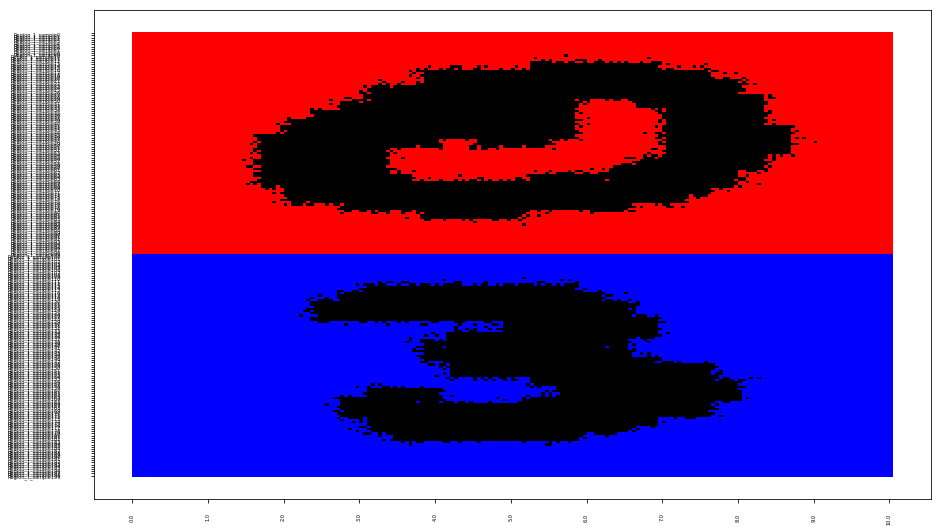

In [127]:
from Ideogram_tools_I import return_ideogram

fig= return_ideogram(ideo, chromosome_list,ID= 'linearDiff_truth_shared',height=9,width= 15)

In [128]:
#### KDE no filter

focus_indexes= [x for x in range(len(label_vector))]

Comparison_threshold= 5
Outlier_threshold= 1e-6
color_ref= ['yellow','red','black','orange','purple','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']
color_ref= ['white','red','black','blue','purple','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']
color_ref= ['red','blue','black','purple','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

Blocks2 = Modules_tools.Merge_class(Windows,focus_indexes,Out,Comparison_threshold,Outlier_threshold)

Ideo_KDE = []
chromosome_list= []
chromosomes= Blocks.keys()

for here in range(len(label_vector)):
    Subject = 'sample' + str(here)
    
    chromosome_list.extend(['Region_'+str(Chr)+ '_' + Subject for Chr in chromosomes])
    
    Stock = [[['Region_'+str(Chr)+ '_' + Subject,bl,Out[Chr][bl],color_ref[Blocks2[Chr][bl][here] - 1]] for bl in sorted(Blocks2[Chr].keys())] for Chr in chromosomes]
    Stock = [y for y in it.chain(*[z for z in it.chain(*[Stock])])]
    
    Ideo_KDE.extend(Stock)

#### begin by compressing assignments by individuals. Lightens the load of the following plot.
import re
ideo_kde = pd.DataFrame(Ideo_KDE,columns = ['chrom', 'start', 'end', 'gieStain'])

# Filter out chromosomes not in our list
ideo_kde = ideo_kde[ideo_kde.chrom.apply(lambda x: x in chromosome_list)]

ideo_kde = Modules_tools.compress_ideo(ideo_kde,Out,chromosome_list)


adding ideograms...


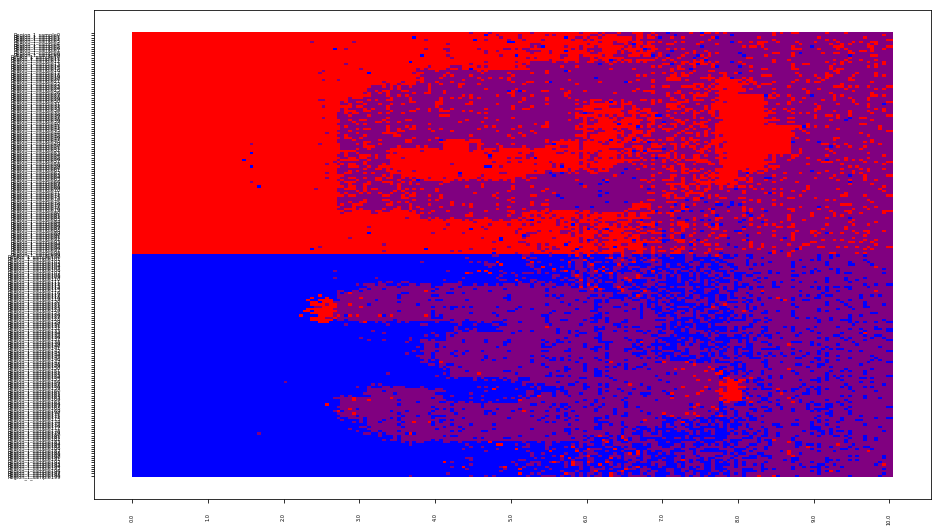

In [129]:
fig= return_ideogram(ideo_kde, chromosome_list,ID= 'linearDiff_kde_shared',height=9,width= 15)